__<span style="background-color:#ffffe0">第3章　時系列予測モデル構築・超入門</span>__

# 3.3　時系列の予測モデルを構築してみよう

##  3.3.9　線形回帰で予測モデルを構築（すべての変数利用）

### 準備（必要なモジュールとデータの読み込み）

In [1]:
#
# 必要なモジュールの読み込み
#

import pandas as pd
import numpy as np
import datetime

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from pmdarima.model_selection import train_test_split

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフのスタイル
plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ設定
plt.rcParams['font.size'] = 14 #フォントサイズ

In [2]:
#
# 必要なデータセット（時系列データ）の読み込み
#

dataset='df_tbl.csv'    #データセットのファイル名
df=pd.read_csv(
    dataset,
    index_col='Month',  #変数「Month」をインデックスに設定
    parse_dates=True)  #インデックスを日付型に設定

print(df) #確認

              y   lag1  lag12    window12   expanding    t
Month                                                     
1950-01-01  115  118.0  112.0  126.666667  126.666667    0
1950-02-01  126  115.0  118.0  126.916667  125.769231    1
1950-03-01  141  126.0  132.0  127.583333  125.785714    2
1950-04-01  135  141.0  129.0  128.333333  126.800000    3
1950-05-01  125  135.0  121.0  128.833333  127.312500    4
...         ...    ...    ...         ...         ...  ...
1960-08-01  606  622.0  559.0  459.416667  273.136691  127
1960-09-01  508  606.0  463.0  463.333333  275.514286  128
1960-10-01  461  508.0  407.0  467.083333  277.163121  129
1960-11-01  390  461.0  362.0  471.583333  278.457746  130
1960-12-01  432  390.0  405.0  473.916667  279.237762  131

[132 rows x 6 columns]


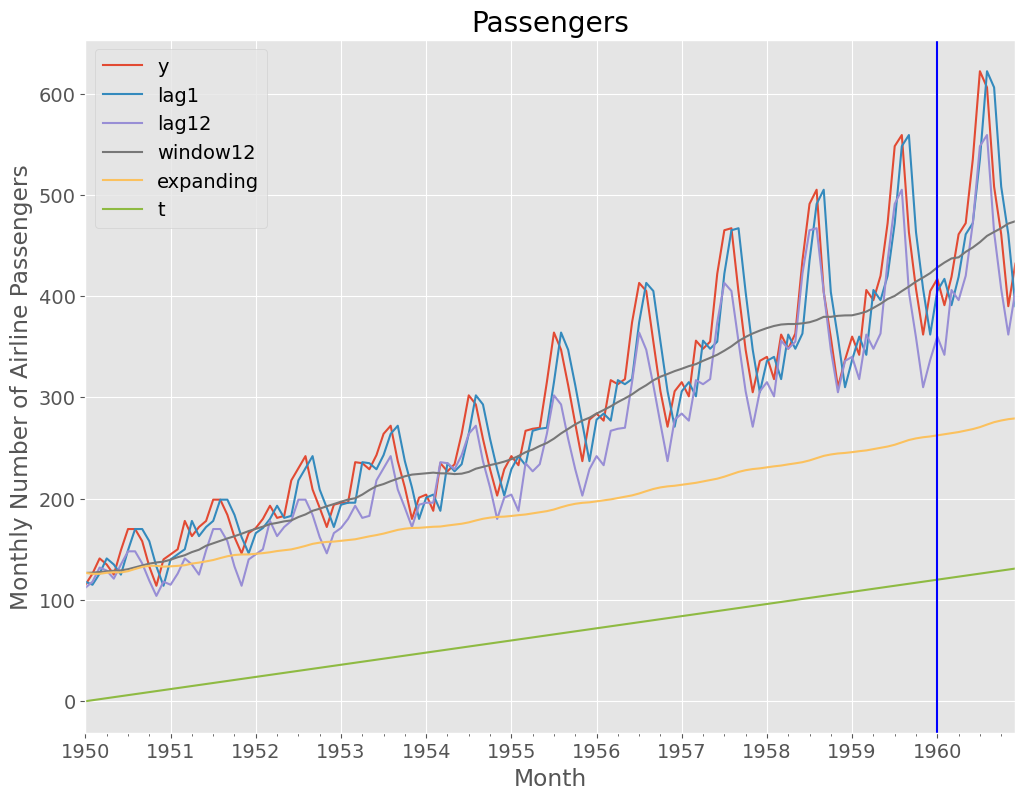

In [3]:
# プロット
df.plot()
plt.title('Passengers')                               #グラフタイトル
plt.ylabel('Monthly Number of Airline Passengers')    #タテ軸のラベル
plt.xlabel('Month')                                   #ヨコ軸のラベル
plt.axvline(datetime.datetime(1960,1,1),color='blue')
plt.show()

In [4]:
#
# データセットを学習データとテストデータ（直近12ヶ月間）に分割
#

# データ分割
train, test = train_test_split(
    df, test_size=12)

# 学習データ
y_train = train['y']              #目的変数y
X_train = train.drop('y', axis=1) #説明変数X

# テストデータ
y_test = test['y']              #目的変数y
X_test = test.drop('y', axis=1) #説明変数X

In [5]:
# テストデータの説明変数X
print(X_test)

             lag1  lag12    window12   expanding    t
Month                                                
1960-01-01  405.0  360.0  428.333333  262.492424  120
1960-02-01  417.0  342.0  433.083333  263.654135  121
1960-03-01  391.0  406.0  437.166667  264.604478  122
1960-04-01  419.0  396.0  438.250000  265.748148  123
1960-05-01  461.0  420.0  443.666667  267.183824  124
1960-06-01  472.0  472.0  448.000000  268.678832  125
1960-07-01  535.0  548.0  453.250000  270.608696  126
1960-08-01  622.0  559.0  459.416667  273.136691  127
1960-09-01  606.0  463.0  463.333333  275.514286  128
1960-10-01  508.0  407.0  467.083333  277.163121  129
1960-11-01  461.0  362.0  471.583333  278.457746  130
1960-12-01  390.0  405.0  473.916667  279.237762  131


### 予測モデルの学習（学習データ利用）

In [6]:
#
# 予測モデルの学習（学習データ利用）
#

# インスタンス生成
regressor = LinearRegression()

# 学習
regressor.fit(X_train, y_train)

# 切片と回帰係数
print('切片:',regressor.intercept_)
print('回帰係数:',regressor.coef_)

切片: 213.27413899926768
回帰係数: [ 0.20388776  0.91028462  0.09268139 -1.84511942  1.74586555]


### 予測モデルのテスト（テストデータ利用）

In [7]:
#
# 予測の実施（学習データ期間）
#

train_pred = regressor.predict(X_train)

In [8]:
#
# 予測の実施（テストデータ期間）
#

# 学習データのコピー
y_train_new = y_train.copy()

# 説明変数Xを更新しながら予測を実施
for i in range(len(y_test)):
    
    #当期の予測の実施
    X_value =  X_test.iloc[i:(i+1),:]
    y_value_pred = regressor.predict(X_value)
    y_value_pred = pd.Series(y_value_pred,index=[X_value.index[0]])
    y_train_new = pd.concat([y_train_new,y_value_pred])
    
    #次期の説明変数Xの計算
    lag1_new = y_train_new.iloc[-1] #lag1
    lag12_new = y_train_new.iloc[-12] #lag12
    window12_new = y_train_new[-12:].mean() #window12
    expanding_new = y_train_new.mean() #expanding
    
    #次期の説明変数Xの更新
    X_test.iloc[(i+1):(i+2),0] = lag1_new
    X_test.iloc[(i+1):(i+2),1] = lag12_new
    X_test.iloc[(i+1):(i+2),2] = window12_new
    X_test.iloc[(i+1):(i+2),3] = expanding_new
    
# 予測値の代入
test_pred = y_train_new[-12:]
    
# 更新後の説明変数X
print(X_test)

                  lag1  lag12    window12   expanding    t
Month                                                     
1960-01-01  405.000000  360.0  428.333333  262.492424  120
1960-02-01  388.423673  342.0  430.701973  277.003501  121
1960-03-01  343.849563  406.0  430.856103  277.551420  122
1960-04-01  393.768839  396.0  429.836840  278.496277  123
1960-05-01  394.751947  420.0  429.732835  279.433823  124
1960-06-01  416.805564  472.0  429.466632  280.532797  125
1960-07-01  468.330282  548.0  429.160822  282.023253  126
1960-08-01  546.984625  559.0  429.076208  284.109563  127
1960-09-01  570.922947  463.0  430.069787  286.350292  128
1960-10-01  486.119892  407.0  431.996444  287.898894  129
1960-11-01  416.920724  362.0  432.823171  288.891370  130
1960-12-01  361.840305  405.0  432.809863  289.448232  131


In [9]:
#
# 予測モデルのテスト（テストデータ利用）
#

print('RMSE:\n',
      np.sqrt(mean_squared_error(
          y_test, test_pred)))
print('MAE:\n',
      mean_absolute_error(
          y_test, test_pred)) 
print('MAPE:\n',
      mean_absolute_percentage_error(
          y_test, test_pred))

RMSE:
 47.743798920634276
MAE:
 44.56768037734101
MAPE:
 0.09334233506617706


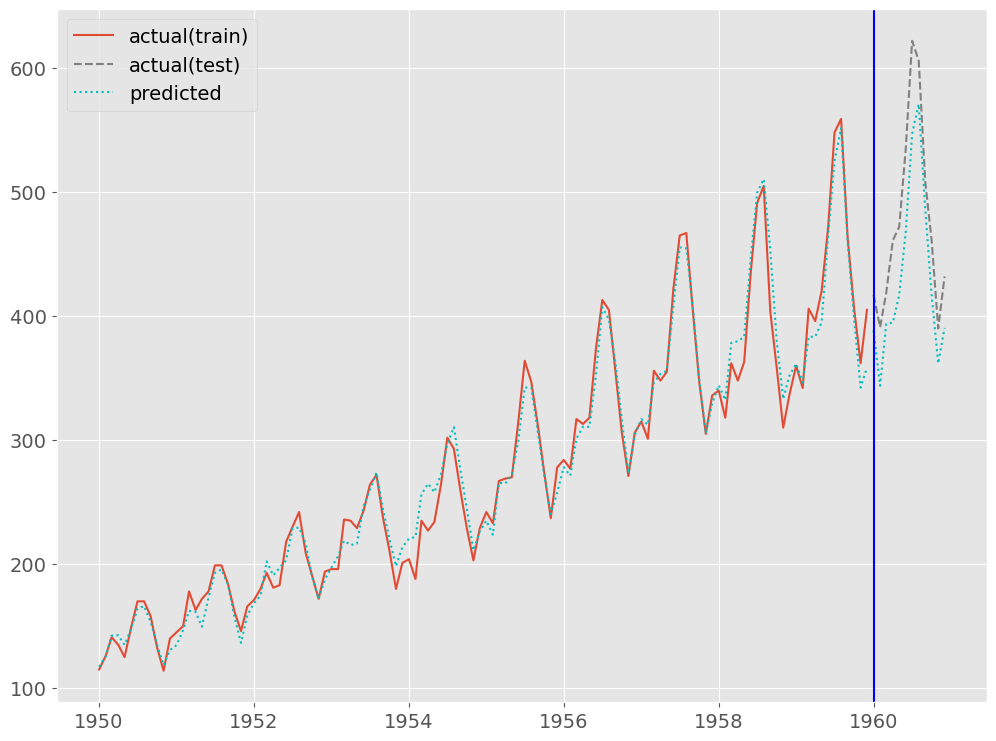

In [10]:
#
# グラフ（予測値と実測値）
#

fig, ax = plt.subplots()

# 実測値の描写
## 学習データ
ax.plot(
    train.index, 
    y_train, 
    linestyle='-',
    label='actual(train)')

## テストデータ
ax.plot(
    test.index, 
    y_test, 
    linestyle='--',
    label='actual(test)', 
    color='gray')

# 予測値の描写
## 学習データ
ax.plot(
    train.index, 
    train_pred, 
    linestyle=':',
    color='c')

## テストデータ
ax.plot(
    test.index, 
    test_pred, 
    linestyle=':',
    label="predicted", 
    color="c") 

# 学習データとテスデータの間の縦線の描写
ax.axvline(
    datetime.datetime(1960,1,1),
    color='blue')

# 凡例表示
ax.legend()

plt.show()